<a href="https://colab.research.google.com/github/sanjib-sen/nlp/blob/master/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Libraries**

In [ ]:
#Data Manipulation
import pandas as pd
import numpy as np

#Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#Scikit-learn
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

#Utility
import re     
import string
import seaborn as sns
from wordcloud import WordCloud

#nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# import nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')  
stop_words = set(stopwords.words('english'))

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Reading and Loading the dataset**

Train Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/CSE437/train.csv')

In [ ]:
train_data.head()
# train_data.columns

,text,Y
0,advice Talk neighbours family exchange phone n...,2
1,Coronavirus Australia: Woolworths give elderly...,2
2,"My food stock one empty... PLEASE, panic, THER...",2
3,"Me, ready go supermarket outbreak. Not I'm par...",0
4,As news regionÂs first confirmed COVID- case ...,2


Test Dataset

In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/CSE437/test.csv')
# test_data.head()
# test_data.columns

Length of both datasets

In [ ]:
print('length of dataset is: ', len(train_data))

length of dataset is:  41152


In [ ]:
print('length of dataset is: ', len(test_data))

length of dataset is:  3798


Shape of the dataset

In [ ]:
train_data.shape
# train_data.info

(41152, 2)

In [ ]:
test_data.shape
# test_data.info

(3798, 2)

Checking Datatypes of all columns

In [ ]:
# train_data.dtypes
#test_data.dtypes

Checking Null Values existing in the dataset

In [ ]:
np.sum(train_data.isnull().any(axis=1))

0

Printing the rows and columns of the dataset

In [ ]:
print('Number of Columns Train Dataset: ', len(train_data.columns))
print('Number of Rows: ', len(train_data))
print('------------------------------------')
print('Number of Columns Test Dataset: ', len(test_data.columns))
print('Number of Rows: ', len(test_data))

Number of Columns Train Dataset:  2
Number of Rows:  41152
------------------------------------
Number of Columns Test Dataset:  2
Number of Rows:  3798


Checking Target Values that are unique

In [ ]:
train_data['text'].unique()

array(['advice Talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist GP set online shopping accounts poss adequate supplies regular meds order',
       'Coronavirus Australia: Woolworths give elderly, disabled dedicated shopping hours amid COVID- outbreak',
       'My food stock one empty... PLEASE, panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE take need. Stay calm, stay safe. france',
       ...,
       'You know itÂ\x92s getting tough rationing toilet paper martinsville, help us out!!',
       'Is wrong smell hand sanitizer starting turn on?',
       'Well new/used Rift S going $ . Amazon rn although normal market price usually $ . . Prices really crazy right vr headsets since HL Alex announced worse COVID- . Up whethe'],
      dtype=object)

Checking the number of target vlaues

In [ ]:
train_data['text'].nunique()

41047

Data Visualization (Target Values)

                                                    text  Y
0      advice Talk neighbours family exchange phone n...  2
1      Coronavirus Australia: Woolworths give elderly...  2
2      My food stock one empty... PLEASE, panic, THER...  2
3      Me, ready go supermarket outbreak. Not I'm par...  0
4      As news regionÂs first confirmed COVID- case ...  2
...                                                  ... ..
41147  Airline pilots offering stock supermarket shel...  1
41148  Response complaint provided citing COVID- rela...  0
41149  You know itÂs getting tough rationing toilet ...  2
41150    Is wrong smell hand sanitizer starting turn on?  1
41151  Well new/used Rift S going $ . Amazon rn altho...  0

[41152 rows x 2 columns]


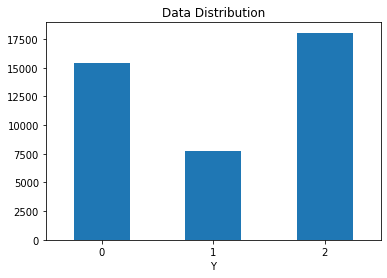

In [ ]:
#Plotting
x = train_data.groupby('Y').count().plot(kind='bar', title='Data Distribution', legend=False)
x.set_xticklabels(['0','1','2'], rotation=0)
print(train_data)
#Data storing in lists
text, sentiment = list(train_data['text']), list(train_data['Y'])

**Oversampling**

In [ ]:
from sklearn.utils import resample
#create two different dataframe of majority and minority class 
df_majority = train_data[(train_data['Y']==0)] 
df_minority = train_data[(train_data['Y']==1)]
df_constant = train_data[(train_data['Y']==2)]  
# upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples= 17500, # to match majority class
                                 random_state=42)  # reproducible results
df_majority_upsampled = resample(df_majority, 
                                 replace=True,    # sample with replacement
                                 n_samples= 17500, # to match majority class
                                 random_state=42)  # reproducible results
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority_upsampled, df_majority_upsampled, df_constant])

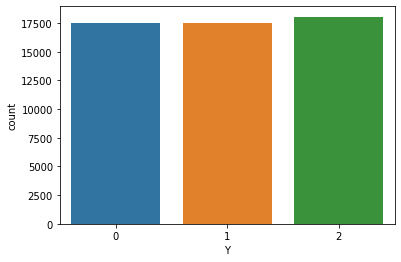

In [ ]:
sns.countplot(x='Y', data=df_upsampled)

In [ ]:
print(df_upsampled.describe()) 

                  Y
count  53046.000000
mean       1.010293
std        0.818538
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        2.000000


**Data Preprocessing**

Printing unique values of the target variables

In [ ]:
data=df_upsampled[['text','Y']]

In [ ]:
data['text'].unique()

array(['New COVID- supermarket restrictions ahead Easter weekend - News',
       'IÂ\x92ve heard supermarket locked staff member contracting Covid-',
       'Went grocery store opened people standing line! So much staying ft away others!',
       ...,
       'I never weÂ\x92d situation &amp; world going supermarket , picking package mail like playing Russian roulette life',
       'definitely man. I feel like fall again, need honor heroes COVID- . You know Â\x97 healthcare people , grocery store owners, anyone else putting life li',
       'You know itÂ\x92s getting tough rationing toilet paper martinsville, help us out!!'],
      dtype=object)

Now separating the positive and negative tweets

In [ ]:
# positive_data = data[data['text'] == 2]
# neutral_data = data[data['text'] == 1]
# negative_data = data[data['text'] == 0]

In [ ]:
positive_data = data[data['Y'] == 2]
neutral_data = data[data['Y'] == 1]
negative_data = data[data['Y'] == 0]

Making text into lowercase

In [ ]:
data['text'] = data['text'].str.lower()
data['text'].tail()

41141    prices rose -year high today due increased bul...
41143    uv light sterilizer sanitizer mask mobile phon...
41145    i never weâd situation &amp; world going supe...
41146    definitely man. i feel like fall again, need h...
41149    you know itâs getting tough rationing toilet ...
Name: text, dtype: object

Defining list of stopwords

In [ ]:
list_of_stopwords = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

Cleaning the stopwords from tweets

In [ ]:
stopwords = set(list_of_stopwords)

def cleaning(text):
    return " ".join([word for word in str(text).split() if word not in stopwords])
data['text'] = data['text'].apply(lambda text: cleaning(text))
data['text'].head()

38900    new covid- supermarket restrictions ahead east...
40677    iâve heard supermarket locked staff member co...
4859     went grocery store opened people standing line...
29610    : merchants , fined hiking prices. meanwhile, ...
28840    @ mins australian supermarket shelves stripped...
Name: text, dtype: object

Cleaning Punctuations from tweets

In [ ]:
punctuations = string.punctuation
list_of_punctuations = punctuations
def cleaning(text):
    translator = str.maketrans('', '', list_of_punctuations)
    return text.translate(translator)
data['text'] = data['text'].apply(lambda text: cleaning(text))
data['text'].tail()

41141    prices rose year high today due increased bull...
41143    uv light sterilizer sanitizer mask mobile phon...
41145    never weâd situation amp world going supermar...
41146    definitely man feel like fall again need honor...
41149    know itâs getting tough rationing toilet pape...
Name: text, dtype: object

Cleaning Repeating Characters

In [ ]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
data['text'] = data['text'].apply(lambda x: cleaning_repeating_char(x))
data['text'].tail()

41141    prices rose year high today due increased bull...
41143    uv light sterilizer sanitizer mask mobile phon...
41145    never weâd situation amp world going supermar...
41146    definitely man feel like fall again need honor...
41149    know itâs getting tough rationing toilet pape...
Name: text, dtype: object

Cleaning URL's

In [ ]:
def clean_URL(data):
    return re.sub("http\S+|www\S+|https\S+", "", data)
data['text'] = data['text'].apply(lambda x: clean_URL(x))
data['text'].tail()

41141    prices rose year high today due increased bull...
41143    uv light sterilizer sanitizer mask mobile phon...
41145    never weâd situation amp world going supermar...
41146    definitely man feel like fall again need honor...
41149    know itâs getting tough rationing toilet pape...
Name: text, dtype: object

Cleaning Numbers

In [ ]:
def clean_num(data):
    return re.sub('[0-9]+', '', data)
data['text'] = data['text'].apply(lambda x: clean_num(x))
data['text'].tail()

41141    prices rose year high today due increased bull...
41143    uv light sterilizer sanitizer mask mobile phon...
41145    never weâd situation amp world going supermar...
41146    definitely man feel like fall again need honor...
41149    know itâs getting tough rationing toilet pape...
Name: text, dtype: object

Stemming

In [ ]:
ps = nltk.PorterStemmer()
def stemming(data):
    text = [ps.stem(word) for word in data]
    return data
data['text'] = data['text'].apply(lambda x: stemming(x))
data['text'].head()

38900    new covid supermarket restrictions ahead easte...
40677    iâve heard supermarket locked staff member co...
4859     went grocery store opened people standing line...
29610     merchants  fined hiking prices meanwhile disp...
28840     mins australian supermarket shelves stripped ...
Name: text, dtype: object

Lemmatizer

In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
lemmatizer = WordNetLemmatizer()
def lemmatizer_text(data):
    text = [lemmatizer.lemmatize(word) for word in data]
    return data
data['text'] = data['text'].apply(lambda x: lemmatizer_text(x))
data['text'].head()

38900    new covid supermarket restrictions ahead easte...
40677    iâve heard supermarket locked staff member co...
4859     went grocery store opened people standing line...
29610     merchants  fined hiking prices meanwhile disp...
28840     mins australian supermarket shelves stripped ...
Name: text, dtype: object

Separation of input and label

In [ ]:
X=data.text
y=data.Y

Positive Tweets

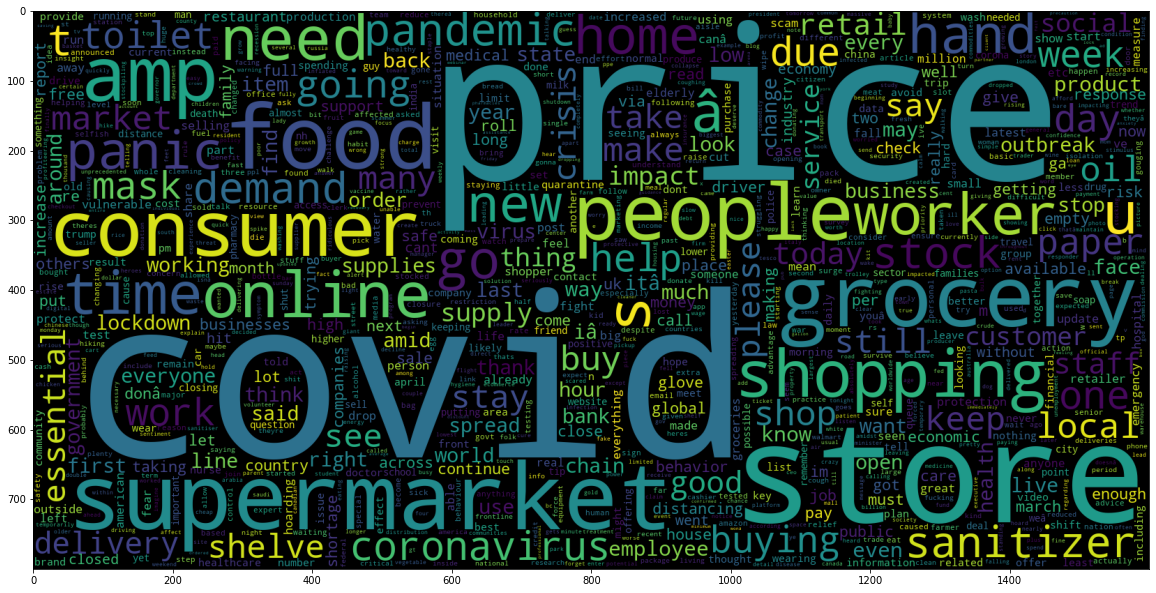

In [ ]:
positive_data = data['text']
# positive_data = positive_data
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate("".join(positive_data))
plt.figure(figsize = (20,20))
plt.imshow(wc)

Negative Tweets

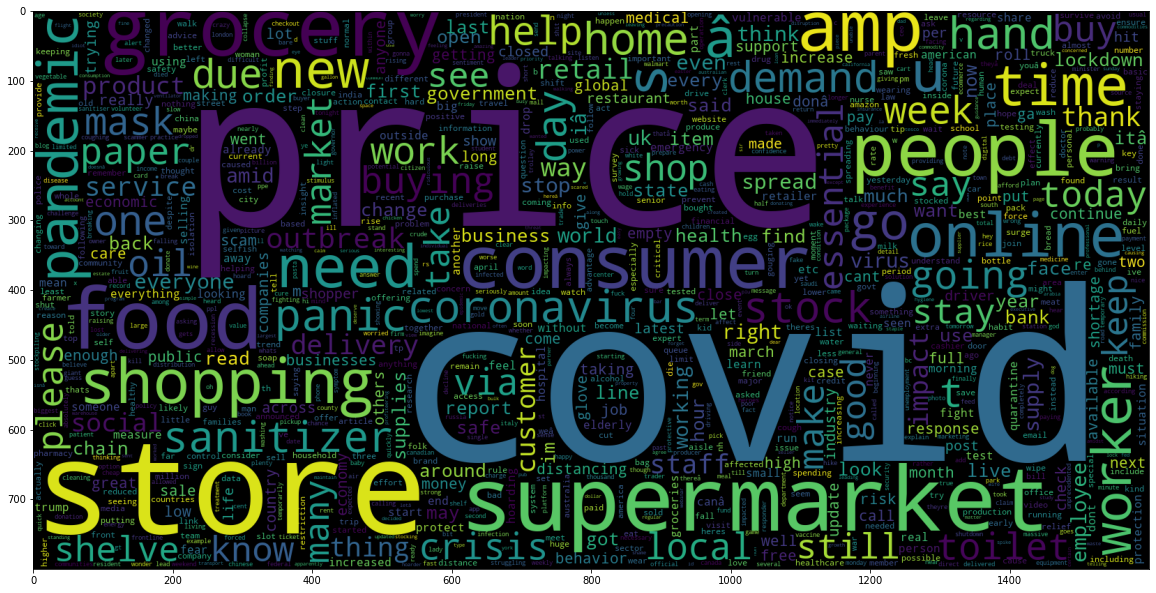

In [ ]:
negative_data = data['text']
# negative_data = negative_data
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(negative_data))
plt.imshow(wc)

Neutral Tweets

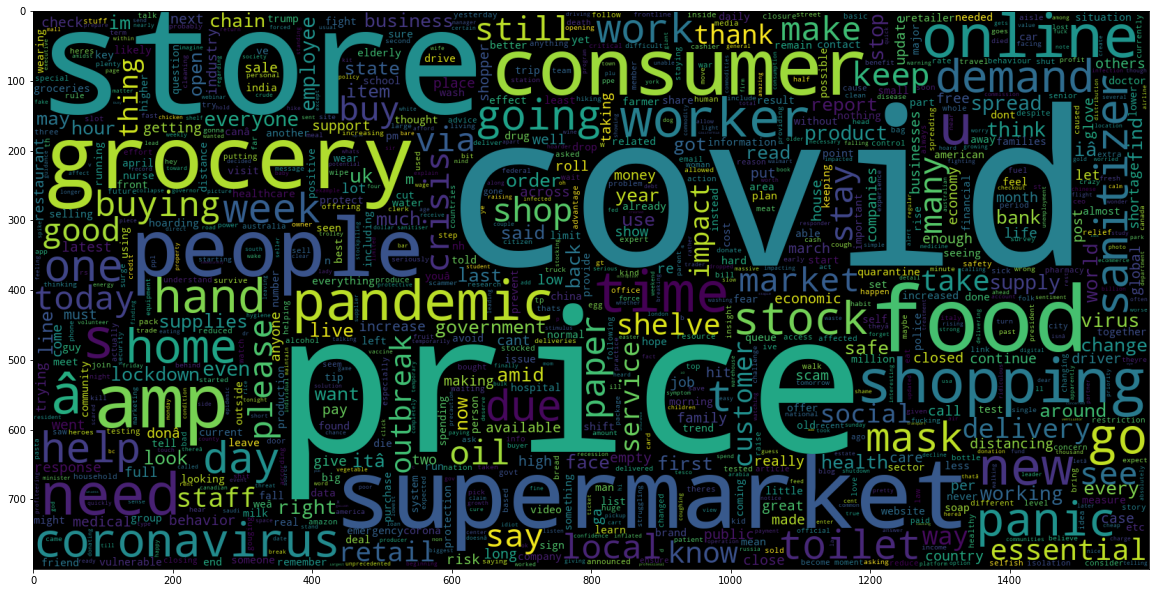

In [ ]:
neutral_data = data['text']
# neutral_data = neutral_data
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(neutral_data))
plt.imshow(wc)

Transforming Dataset into a Vectorizer

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =25)

In [ ]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=5000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))
#----------------------------------------------------------------------------#
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

No. of feature_words:  5000


**Support Vector Classification (SVC)**

In [ ]:
def model_Evaluate(model):
# Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive','Neutral']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = True, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.88      0.85      0.87       909
           1       0.82      0.92      0.87       831
           2       0.88      0.80      0.84       913

    accuracy                           0.86      2653
   macro avg       0.86      0.86      0.86      2653
weighted avg       0.86      0.86      0.86      2653



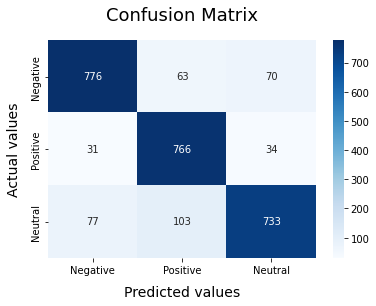

In [ ]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(5000)
validation_sentence = ['I am sad']
validation_sentence_tockened = tokenizer.texts_to_sequences(validation_sentence)
validation_sentence_padded = pad_sequences(validation_sentence_tockened, maxlen=5000, truncating ='post', padding='post')
# print(validation_sentence[0])
print(np.argmax(SVCmodel.predict(validation_sentence_padded)[0]))

0


**Random Forest Classifier (RFC)**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

text_classifier = RandomForestClassifier(n_estimators=200, random_state=25)
text_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=25)

In [ ]:
predictions = text_classifier.predict(X_test)

              precision    recall  f1-score   support

           0       0.90      0.87      0.88       909
           1       0.87      0.98      0.92       831
           2       0.89      0.81      0.84       913

    accuracy                           0.88      2653
   macro avg       0.88      0.89      0.88      2653
weighted avg       0.88      0.88      0.88      2653



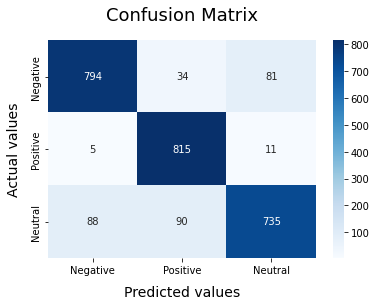

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
model_Evaluate(text_classifier)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(5000)
validation_sentence = ['All month crowding supermarkets restaurants, however reducing hours closing malls means everyone using entrance dependent single supermarket.']
validation_sentence_tockened = tokenizer.texts_to_sequences(validation_sentence)
validation_sentence_padded = pad_sequences(validation_sentence_tockened, maxlen=5000, truncating ='post', padding='post')
print(validation_sentence[0])
print(np.argmax(text_classifier.predict(validation_sentence_padded)[0]))

All month crowding supermarkets restaurants, however reducing hours closing malls means everyone using entrance dependent single supermarket.
0


**Logistic Regression**

In [ ]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

0.8326422917451941

              precision    recall  f1-score   support

           0       0.87      0.84      0.85       909
           1       0.81      0.91      0.85       831
           2       0.87      0.80      0.83       913

    accuracy                           0.85      2653
   macro avg       0.85      0.85      0.85      2653
weighted avg       0.85      0.85      0.85      2653



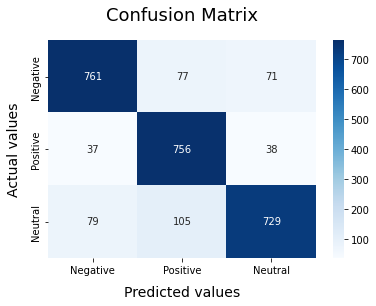

In [ ]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(5000)
validation_sentence = ['All month crowding supermarkets restaurants, however reducing hours closing malls means everyone using entrance dependent single supermarket.']
validation_sentence_tockened = tokenizer.texts_to_sequences(validation_sentence)
validation_sentence_padded = pad_sequences(validation_sentence_tockened, maxlen=5000, truncating ='post', padding='post')
print(validation_sentence[0])
print(np.argmax(clf.predict(validation_sentence_padded)[0]))

All month crowding supermarkets restaurants, however reducing hours closing malls means everyone using entrance dependent single supermarket.
0
